# ARES
The Accelerated Reionization Era Simulations ([`ARES`](https://ares.readthedocs.io/en/latest/index.html)) code was designed to rapidly generate models for the global 21-cm signal.

Based on [Muñoz et al., 2015](https://journals.aps.org/prd/abstract/10.1103/PhysRevD.92.083528), we added `ares/physics/DarkMatterHeating.py` to the original ARES to discuss the heating of baryons due to scattering with dark matter during the dark ages.

Following is a documentation about using `test_fitting_dm.py` to fit dark matter mass, `m_chi`, and the R.M.S. of streaming velocity, `V_rms`, between dark matter and gas, given 21-cm temperature signals, `dTb`, and the correponding redshifts, `z`.

Be warned: this code is still under active development – use at your own risk! Correctness of results is not guaranteed.

## Citation
If you use this code in paper please reference [TBD]() if it’s an application of fitting dark matter mass and R.M.S. of streaming velocity.

## Dependencies
You will need:
- numpy
- scipy
- matplotlib
- h5py
## Getting started
To clone a copy and install:
```
git clone https://github.com/Xsmos/ares.git
cd ares
python setup.py install
```
`ares` will look in `ares/input` for lookup tables of various kinds. To download said lookup tables, run
```
python remote.py
```
Check out the original [**ares**](https://ares.readthedocs.io/en/latest/install.html) for more details about installing the lookup tables.

## Parameters:
- `z_sample`: a 1-D array of redshifts.
- `dTb_sample`: a 2-D array of brightness temperatures in unit of `mK`. `dTb_sample.shape[1]` must be equal to `z_sample.shape[0]`.
- `param_guess`: the initial guess for the parameters `[m_chi, V_rms]` in units of `GeV` and `m/s`, respectively. Default is `[0.1, 29000]`.
- `cores`: number of CPUs to calculate the `dTb`s for different initial streaming velocites. Default is 1.
- `average_dir`: name of the directory to save the averaged dTb's. Default is `'dTb_averaged'`.
- `save_name`: name of the file to save the fitting results. Default is `'m_chi-V_rms.npy'`.
- `N_v_streams`: number of initial streaming velocities to be generated equally-spaced between `[0, 3*V_rms]` in order to calculate the averaged global `dTb`. Default is 12.
- `verbose`: 0 for showing the final fitting results only, 1 for including intermediate results of the fitting process. Default is 1.
- `bounds`: Lower and upper bounds on independent variables. Default is [[0.001,10000],[100,100000]]

## Example:

In [ ]:
import numpy as np
from test_fitting_dm import interp_dTb, fit_param

cores = 24
N_v_streams = 24

# assumptions about the dark matter mass and rms stream velocity
m_chi_true = 0.2 # GeV
V_rms_true = 35000 # m/s

# sampling
N_observations = 50 # number of observations
z_sample = np.linspace(0, 1100, 300) # redshifts corresponding to these observations
dTb_accurate = interp_dTb(param=[m_chi_true, V_rms_true], z=z_sample, cores=cores, N_v_streams=N_v_streams, verbose=1)
noise = 1 # mK. std of the signal noise, assumed to be Gaussian and frequency-independent
dTb_sample = dTb_accurate + noise * np.random.normal(size=(N_observations, z_sample.shape[0]))

# fitting
fit_result = fit_param(z_sample, dTb_sample, cores=cores, N_v_streams=N_v_streams, save_name=f"m_chi{m_chi_true}-V_rms{V_rms_true}-N_v_stream{N_v_streams}.npy", verbose=0)

24 v_streams will be generated for m_chi = 0.2 GeV and V_rms = 35000 m/s...
Sampling 24 dTb's by 24 CPUs parallelly...
It costs 0:00:09.036404 to calculate dTb of 24 different initial_v_streams by 24 CPUs.
---------------------------------------------
Fitting starts...
#1, res: [2.00570680e-01 3.50485659e+04], cost: 0:04:23.184918
#2, res: [2.04540090e-01 3.48966342e+04], cost: 0:04:15.684377
#3, res: [1.98753499e-01 3.54711695e+04], cost: 0:04:24.435284
#4, res: [1.90978709e-01 3.53869497e+04], cost: 0:04:16.956910
#5, res: [2.08998215e-01 3.46486289e+04], cost: 0:04:53.586268
#6, res: [2.06181664e-01 3.45366870e+04], cost: 0:02:25.278067
#7, res: [2.02525391e-01 3.49339606e+04], cost: 0:05:59.812197
#8, res: [1.97253994e-01 3.51082213e+04], cost: 0:03:26.805896
#9, res: [2.01590779e-01 3.46131009e+04], cost: 0:03:09.384673
#10, res: [2.01531793e-01 3.44873676e+04], cost: 0:03:36.686812
#11, res: [1.80557420e-01 3.64712674e+04], cost: 0:03:25.724058
#12, res: [1.95270443e-01 3.5197682

We can see that the fitting process generally takes about $N_{observations}*\lceil\frac{N_{v_{streams}}}{cores}\rceil*4$ minutes.
## Analysis:

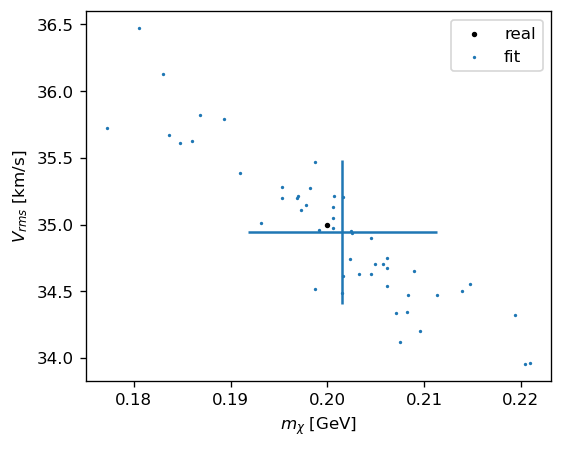

In [11]:
import os
import matplotlib.pyplot as plt

fig = plt.figure(dpi=120, figsize=(5,4))
fit_median = {}
for filename in os.listdir():
    # one assumes all .npy file in current directory have m_chi*V_rms*.npy format.
    if ".npy" in filename:
        real_value = filename.split(sep="-")
        fit_data = np.load(filename)
        fit_median[filename] = np.median(fit_data, axis=0)
        plt.scatter(float(real_value[0][5:]), float(real_value[1][5:])/1000, c='k', label='real', s=5)
        plt.scatter(fit_data[:,0], fit_data[:,1]/1000, label='fit', s=1)
        plt.errorbar(fit_median[filename][0], fit_median[filename][1]/1000, xerr=np.std(fit_data[:,0]), yerr=np.std(fit_data[:,1])/1000)
        # print(filename, fit_median[filename])
plt.xlabel(r"$m_{\chi}$ [GeV]")
plt.ylabel(r"$V_{rms}$ [km/s]")
plt.legend()
plt.show()

The distribution of scatter points from upper left to lower right comes from the degeneracy of the effects of m_chi and V_rms on dTb。

In [15]:
import ares
fig = plt.figure(dpi=120, figsize=(5,4))

pf = \
    {
        'radiative_transfer': False,
        'verbose': False,
        'dark_matter_heating': False,
        'include_cgm': False,
        'initial_redshift': 1010,
        'include_He': True
    }
sim = ares.simulations.Global21cm(**pf)
sim.run()
plt.plot(sim.history['z'], sim.history['dTb'], label="no DM heating")

plt.plot(z_sample, dTb_accurate, label=f'real: [{m_chi_true}, {V_rms_true}]', c='k')
plt.scatter(z_sample, dTb_sample[0], label=f'sample: noise = {noise}', s=0.5, c='grey')

for filename in os.listdir():
    # one assumes all .npy file in current directory have m_chi*V_rms*.npy format.
    if ".npy" in filename:
        dTb_fit = interp_dTb(param=fit_median[filename], z=z_sample, cores=cores, N_v_streams=N_v_streams, verbose=1)
        plt.plot(z_sample, dTb_fit, label=f'fit: [{fit_median[filename][0]:.3f}, {fit_median[filename][1]:.3f}]', linestyle='--')
plt.xlabel('z')
plt.ylabel('dTb [mK]')
plt.xlim(0,300)
plt.legend()
plt.show()

24 v_streams will be generated for m_chi = 0.20156128597891154 GeV and V_rms = 34944.43068580591 m/s...
Sampling 24 dTb's by 24 CPUs parallelly...

It can be seen from the figure that the fitted curve coincides with the noise-free curve to a very high degree.

In [13]:
import numpy as np
from test_fitting_dm import interp_dTb, fit_param

cores = 2
N_v_streams = 24

# assumptions about the dark matter mass and rms stream velocity
m_chi_true = 0.2 # GeV
V_rms_true = 35000 # m/s

# sampling
N_observations = 50 # number of observations
z_sample = np.linspace(0, 1100, 300) # redshifts corresponding to these observations
dTb_accurate = interp_dTb(param=[m_chi_true, V_rms_true], z=z_sample, cores=cores, N_v_streams=N_v_streams, verbose=1)
noise = 1 # mK. std of the signal noise, assumed to be Gaussian and frequency-independent
dTb_sample = dTb_accurate + noise * np.random.normal(size=(N_observations, z_sample.shape[0]))

# fitting
fit_result = fit_param(z_sample, dTb_sample, cores=cores, N_v_streams=N_v_streams, save_name=f"m_chi{m_chi_true}-V_rms{V_rms_true}-N_v_stream{N_v_streams}.npy", verbose=0)

24 v_streams will be generated for m_chi = 0.2 GeV and V_rms = 35000 m/s...
Sampling 24 dTb's by 2 CPUs parallelly...


It costs 0:04:03.456180 to calculate dTb of 24 different initial_v_streams by 2 CPUs.
---------------------------------------------
Fitting starts...
kwargs = {'N_v_streams': 24, 'verbose': 0, 'bounds': array([[1.e-03, 1.e+04],
       [1.e+02, 1.e+05]])}


KeyboardInterrupt: 

In [14]:
cores=24